# Sea ice extent boxplots and errors calculations

## Objective

The goal of this notebook is to compare the sea ice cover simulated by each model with the observed data. At the same time, absolute errors will be calculated and compared. This will allow us to identify outlier models that should be excluded or given less weight in future analyses. Finally, various scoring functions have been tested to determine which one penalizes poor models the most. Therefore, this notebook presents the complete set of statistical analyses.

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-07-23T10:14:26.009100+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-63-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import sys
import os

# absolute path to the folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# adding the path to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Projet root ajouté au path:", project_root)

Projet root ajouté au path: /home/jovyan/M2_SeaIce_project


In [3]:
from module import *

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [4]:
%watermark --iversions

csv       : 1.0
pandas    : 2.2.3
xesmf     : 0.8.8
seaborn   : 0.13.2
xarray    : 2025.1.1
netCDF4   : 1.7.2
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
watermark : 2.5.0
numpy     : 2.0.2
skimage   : 0.25.0
matplotlib: 3.10.0
cdo       : 1.6.1
cartopy   : 0.24.0



## Sea ice reference

In [5]:
path_seaice = "/home/jovyan/M2_SeaIce_project/Data/input_data/seaice_extent_km2_nh.nc"
seaice_cover_km2_nh = xr.open_dataarray(path_seaice)

In [6]:
seaice_cover_km2_nh.values

array([14735404.05653074, 15633530.48923884, 15891210.76005795,
       14984313.64542002, 13648460.88874055, 12083078.30437279,
       10602611.3847339 ,  8531651.02719152,  7573693.21616463,
        9194412.27093241, 11098435.40545183, 12995679.00734808])

## Visualizing the average monthly sea ice coverage based on historical data

In [7]:
# open the csv file
seaice_hist = pd.read_csv("/home/jovyan/private-storage/output_data/seaice_cover_per_model25.csv")
seaice_hist

,modèle,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,BCC-CSM2-MR,1.058056e+07,1.128198e+07,1.161661e+07,1.104648e+07,9.777131e+06,8.235568e+06,5.969503e+06,4.456924e+06,3.983553e+06,5.210928e+06,6.982979e+06,9.137182e+06
1,CAMS-CSM1-0,1.847449e+07,1.971748e+07,1.987622e+07,1.889737e+07,1.658861e+07,1.393529e+07,1.109768e+07,8.603986e+06,8.389866e+06,1.000351e+07,1.303129e+07,1.611295e+07
2,CESM2,1.233882e+07,1.297282e+07,1.318507e+07,1.306662e+07,1.226018e+07,1.121748e+07,9.040889e+06,6.218345e+06,4.624258e+06,6.491907e+06,9.145515e+06,1.100381e+07
3,CESM2-WACCM,1.270387e+07,1.326296e+07,1.349978e+07,1.347113e+07,1.278507e+07,1.149277e+07,9.261971e+06,7.580732e+06,6.300693e+06,7.686300e+06,9.583092e+06,1.134681e+07
4,CNRM-CM6-1,1.268280e+07,1.339549e+07,1.359311e+07,1.309859e+07,1.216098e+07,1.068147e+07,8.555079e+06,7.038537e+06,6.051964e+06,7.149242e+06,9.291937e+06,1.138585e+07
5,CNRM-CM6-1-HR,1.369916e+07,1.448807e+07,1.456513e+07,1.420655e+07,1.341164e+07,1.179525e+07,9.251771e+06,8.070535e+06,7.080148e+06,8.309372e+06,9.909597e+06,1.250125e+07
6,CanESM5,1.265890e+07,1.344047e+07,1.382435e+07,1.372341e+07,1.256774e+07,1.085906e+07,8.905035e+06,7.195976e+06,6.763621e+06,8.129205e+06,9.311933e+06,1.095548e+07
7,FGOALS-f3-L,1.311407e+07,1.412275e+07,1.441963e+07,1.379265e+07,1.220272e+07,1.087706e+07,8.839902e+06,6.959792e+06,5.822922e+06,7.703019e+06,9.289376e+06,1.154546e+07
8,FIO-ESM-2-0,1.135175e+07,1.214835e+07,1.236708e+07,1.204442e+07,1.112202e+07,1.005972e+07,8.063146e+06,4.231333e+06,3.078043e+06,4.975479e+06,8.036364e+06,9.863972e+06
9,GFDL-CM4,1.315663e+07,1.373428e+07,1.380256e+07,1.346532e+07,1.235088e+07,1.093139e+07,8.597647e+06,7.441183e+06,6.949808e+06,8.414279e+06,9.825296e+06,1.185014e+07


### Adding a reference to this DataFrame and calculating the annual average

In [8]:
# List of months
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Add the "reference" row
reference_row = {"modèle": "reference"}
reference_row.update({month: val for month, val in zip(month_names, seaice_cover_km2_nh.values)})

# Append the row to the existing DataFrame
seaice_hist = pd.concat([seaice_hist, pd.DataFrame([reference_row])], ignore_index=True)

# Add a column for the annual average
seaice_hist["ann"] = seaice_hist[month_names].mean(axis=1)

In [9]:
# Display the last rows of the DataFrame for verification
seaice_hist.tail()

,modèle,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
15,MIROC6,1.091094e+07,1.139765e+07,1.161581e+07,1.141794e+07,1.072098e+07,9.836207e+06,8.186128e+06,7.015225e+06,6.768637e+06,8.123526e+06,8.856690e+06,9.818507e+06,9.555687e+06
16,MPI-ESM1-2-HR,1.385582e+07,1.484327e+07,1.521365e+07,1.481863e+07,1.351861e+07,1.162006e+07,8.951846e+06,6.565155e+06,6.140168e+06,7.568239e+06,9.884471e+06,1.184639e+07,1.123553e+07
17,MRI-ESM2-0,1.294889e+07,1.364723e+07,1.382795e+07,1.346667e+07,1.237460e+07,1.086174e+07,8.880043e+06,6.967831e+06,6.068810e+06,7.333837e+06,9.426433e+06,1.154598e+07,1.061250e+07
18,NESM3,1.476713e+07,1.589897e+07,1.660792e+07,1.665467e+07,1.593497e+07,1.404907e+07,9.585577e+06,6.779571e+06,6.040136e+06,7.651250e+06,9.420382e+06,1.260394e+07,1.216613e+07
19,reference,1.473540e+07,1.563353e+07,1.589121e+07,1.498431e+07,1.364846e+07,1.208308e+07,1.060261e+07,8.531651e+06,7.573693e+06,9.194412e+06,1.109844e+07,1.299568e+07,1.224771e+07


In [10]:
# Convert to long format
seaice_hist_long = seaice_hist.melt(id_vars='modèle', var_name='Month', value_name='seaice_extent')
seaice_hist_long

,modèle,Month,seaice_extent
0,BCC-CSM2-MR,jan,1.058056e+07
1,CAMS-CSM1-0,jan,1.847449e+07
2,CESM2,jan,1.233882e+07
3,CESM2-WACCM,jan,1.270387e+07
4,CNRM-CM6-1,jan,1.268280e+07
...,...,...,...
255,MIROC6,ann,9.555687e+06
256,MPI-ESM1-2-HR,ann,1.123553e+07
257,MRI-ESM2-0,ann,1.061250e+07
258,NESM3,ann,1.216613e+07


In [11]:
# Extract reference data
ref_data = seaice_hist_long[seaice_hist_long['modèle'] == 'reference']
ref_data

,modèle,Month,seaice_extent
19,reference,jan,1.473540e+07
39,reference,feb,1.563353e+07
59,reference,mar,1.589121e+07
79,reference,apr,1.498431e+07
99,reference,may,1.364846e+07
119,reference,jun,1.208308e+07
139,reference,jul,1.060261e+07
159,reference,aug,8.531651e+06
179,reference,sep,7.573693e+06
199,reference,oct,9.194412e+06


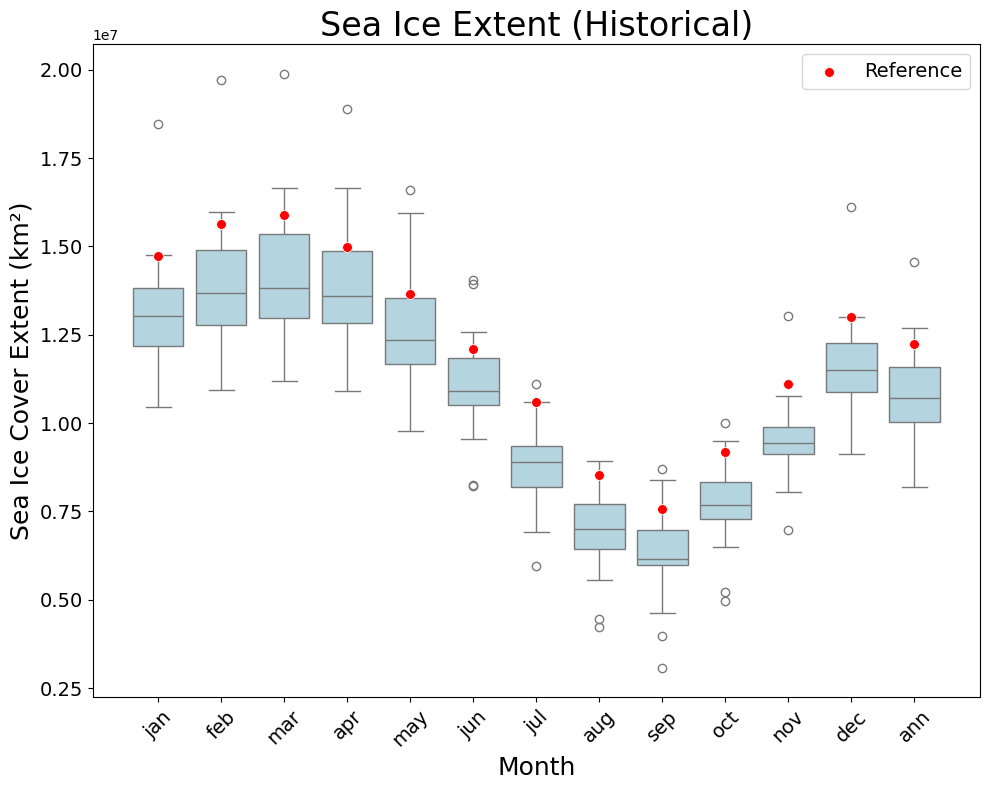

In [12]:
# Generate a boxplot of monthly sea ice extent using historical data, comparing it with the reference dataset
plot_monthly_seaice_boxplot(
    df_long=seaice_hist_long,
    reference_df=ref_data,
    title="Sea Ice Extent (Historical)",
    save_path=None  # or "figures/historical_seaice_extent.png" (if you want to save the figure)
)

Boxplot showing the monthly distribution of sea ice extent from historical data. 

The reference data is highlighted for comparison. In this figure, we can see that the reference data (red points) generally up the ranges defined by the models, indicating bad agreement between observations and simulations. However, we also notice that some points fall outside the boxes’ ranges—these are the outliers identified in this analysis.

### Identification of outliers

In [13]:
# Calculate outliers present in the figure above
outliers = []

# Detect outliers for each month
for mois in seaice_hist_long['Month'].unique():
    valeurs = seaice_hist_long[seaice_hist_long['Month'] == mois]['seaice_extent']
    q1 = valeurs.quantile(0.25)
    q3 = valeurs.quantile(0.75)
    iqr = q3 - q1 #(interquantile range)
    seuil_bas = q1 - 1.5 * iqr
    seuil_haut = q3 + 1.5 * iqr

    # Select outliers
    outliers_mois = seaice_hist_long[
        (seaice_hist_long['Month'] == mois) &
        ((seaice_hist_long['seaice_extent'] < seuil_bas) | (seaice_hist_long['seaice_extent'] > seuil_haut))
    ]
    outliers.append(outliers_mois)

# Combine all monthly outliers into a single DataFrame
outliers_df = pd.concat(outliers)

In [14]:
# Display outliers
outliers_df

,modèle,Month,seaice_extent
1,CAMS-CSM1-0,jan,1.847449e+07
21,CAMS-CSM1-0,feb,1.971748e+07
41,CAMS-CSM1-0,mar,1.987622e+07
61,CAMS-CSM1-0,apr,1.889737e+07
81,CAMS-CSM1-0,may,1.658861e+07
100,BCC-CSM2-MR,jun,8.235568e+06
101,CAMS-CSM1-0,jun,1.393529e+07
114,MIROC-ES2L,jun,8.227473e+06
118,NESM3,jun,1.404907e+07
120,BCC-CSM2-MR,jul,5.969503e+06


This table shows which models fall outside the interval, specifying for each the month and the corresponding sea ice cover value.

### Calculation of absolute errors

In [15]:
# Create a new DataFrame by merging with reference data on 'Month'
df_avec_erreur = seaice_hist_long.merge(ref_data, on='Month', how='left')
df_avec_erreur

,modèle_x,Month,seaice_extent_x,modèle_y,seaice_extent_y
0,BCC-CSM2-MR,jan,1.058056e+07,reference,1.473540e+07
1,CAMS-CSM1-0,jan,1.847449e+07,reference,1.473540e+07
2,CESM2,jan,1.233882e+07,reference,1.473540e+07
3,CESM2-WACCM,jan,1.270387e+07,reference,1.473540e+07
4,CNRM-CM6-1,jan,1.268280e+07,reference,1.473540e+07
...,...,...,...,...,...
255,MIROC6,ann,9.555687e+06,reference,1.224771e+07
256,MPI-ESM1-2-HR,ann,1.123553e+07,reference,1.224771e+07
257,MRI-ESM2-0,ann,1.061250e+07,reference,1.224771e+07
258,NESM3,ann,1.216613e+07,reference,1.224771e+07


In [16]:
# Calculate the absolute error (simulated snow - reference snow)
df_avec_erreur['Erreur_absolue'] = (df_avec_erreur['seaice_extent_x'] - df_avec_erreur['seaice_extent_y']).abs()

#### Visualize as a heatmap

In [17]:
# Force the order of months to avoid alphabetical sorting
ordre_mois = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
              'sep', 'oct', 'nov', 'dec', 'ann']

# Reshape data from long to wide format
df_absolu = df_avec_erreur[df_avec_erreur['modèle_x'] !='reference'].pivot(index='modèle_x', columns='Month', values='Erreur_absolue')
df_absolu = df_absolu[ordre_mois]

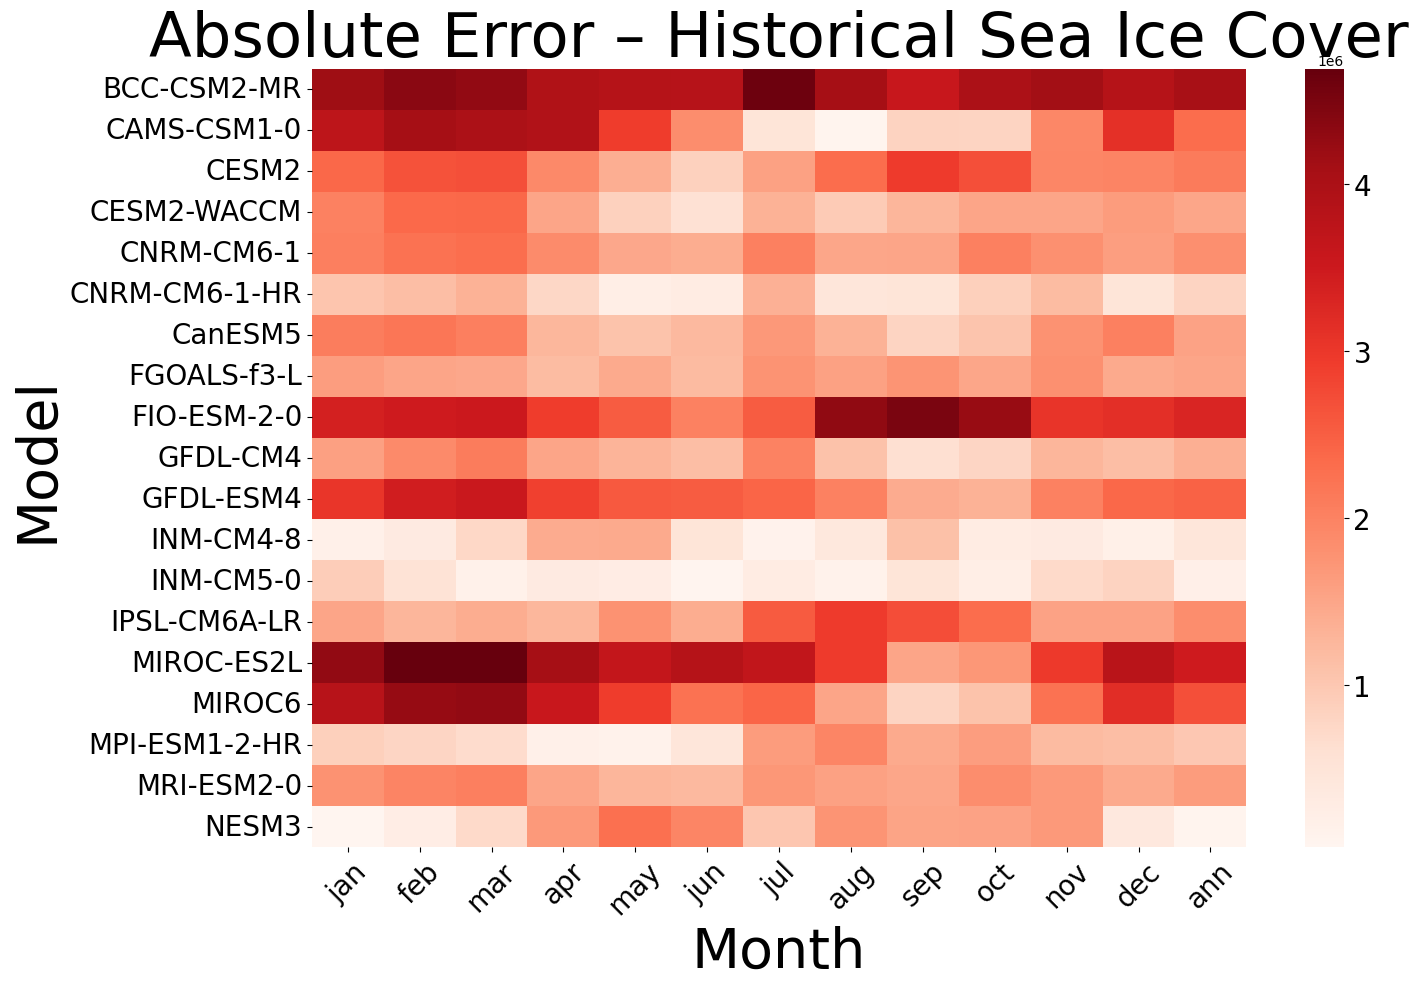

In [18]:
# Plot a heatmap of absolute errors in historical sea ice cover
plot_heatmap_errors(
    data=df_absolu,
    title="Absolute Error – Historical Sea Ice Cover",
    fontsize_title=45,
    fontsize_labels=40,
    fontsize_ticks=20,
    save_path=None  # or 'figures/absolute_error_historical.png'
)

### Calculation of relative errors

In [19]:
# Calculation of relative errors (in %)
df_avec_erreur['Erreur_relative'] = (((df_avec_erreur['seaice_extent_x'] - df_avec_erreur['seaice_extent_y'])/df_avec_erreur['seaice_extent_y'])*100).abs()

#### Visualize as a heatmap

In [20]:
# Convert data from long to wide format
df_relative = df_avec_erreur[df_avec_erreur['modèle_x'] !='reference'].pivot(index='modèle_x', columns='Month', values='Erreur_relative')
df_relative = df_relative[ordre_mois]

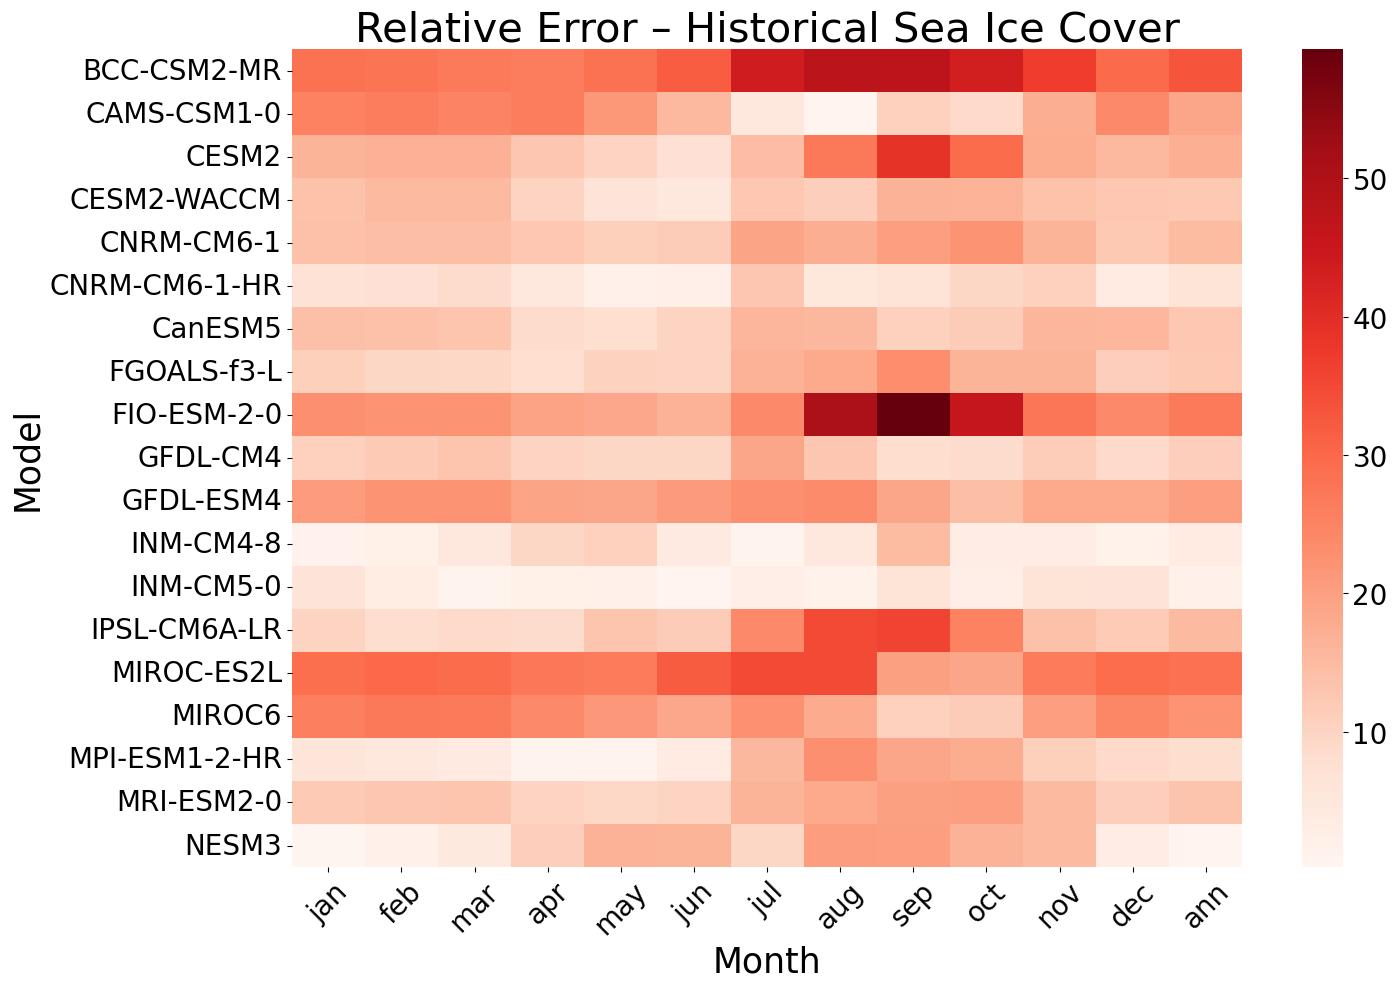

In [21]:
#Plot a heatmap of relative errors in historical sea ice cover
plot_heatmap_errors(
    data=df_relative,
    title="Relative Error – Historical Sea Ice Cover",
    fontsize_title=30,
    fontsize_labels=25,
    fontsize_ticks=20,
    save_path=None  # ou 'figures/absolute_error_historical.png'
)

## Determine the ranking of each model

To identify the best and worst models, we rank them based on their absolute errors.

In [22]:
# Drop annual values and display last rows
erreurs_absolues_mensuelles_hist = df_absolu.drop(columns=['ann'])
erreurs_absolues_mensuelles_hist.tail()

Month,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
modèle_x,,,,,,,,,,,,
MIROC-ES2L,4.272139e+06,4.684269e+06,4.690594e+06,4.087302e+06,3.640840e+06,3.855605e+06,3.676676e+06,2.957872e+06,1.520913e+06,1.724117e+06,2.962967e+06,3.787551e+06
MIROC6,3.824468e+06,4.235876e+06,4.275397e+06,3.566372e+06,2.927480e+06,2.246872e+06,2.416484e+06,1.516426e+06,8.050560e+05,1.070886e+06,2.241745e+06,3.177172e+06
MPI-ESM1-2-HR,8.795857e+05,7.902593e+05,6.775560e+05,1.656792e+05,1.298514e+05,4.630188e+05,1.650766e+06,1.966496e+06,1.433525e+06,1.626173e+06,1.213965e+06,1.149289e+06
MRI-ESM2-0,1.786518e+06,1.986300e+06,2.063261e+06,1.517642e+06,1.273861e+06,1.221336e+06,1.722569e+06,1.563820e+06,1.504883e+06,1.860575e+06,1.672002e+06,1.449701e+06
NESM3,3.172775e+04,2.654438e+05,7.167131e+05,1.670353e+06,2.286508e+06,1.965988e+06,1.017035e+06,1.752080e+06,1.533557e+06,1.543162e+06,1.678054e+06,3.917417e+05


In [23]:
# Compute the mean of absolute errors
classement_modeles = erreurs_absolues_mensuelles_hist.mean(axis=1)

In [24]:
# Sort the values in ascending order
classement_modeles.sort_values(ascending=True, inplace=True)
print(classement_modeles)

modèle_x
INM-CM5-0        4.146250e+05
INM-CM4-8        5.910951e+05
CNRM-CM6-1-HR    8.070010e+05
MPI-ESM1-2-HR    1.012180e+06
NESM3            1.237697e+06
GFDL-CM4         1.371089e+06
CESM2-WACCM      1.499774e+06
FGOALS-f3-L      1.523594e+06
CanESM5          1.553108e+06
MRI-ESM2-0       1.635206e+06
CNRM-CM6-1       1.823952e+06
IPSL-CM6A-LR     1.857300e+06
CESM2            2.117232e+06
CAMS-CSM1-0      2.313022e+06
GFDL-ESM4        2.468479e+06
MIROC6           2.692019e+06
FIO-ESM-2-0      3.302567e+06
MIROC-ES2L       3.488404e+06
BCC-CSM2-MR      4.057757e+06
dtype: float64


Here, the models are ranked in ascending order based on their absolute error values. The first model has the lowest erreor, and the last one the highest.

## Assigning a score to each model

Based on the mean absolute errors, a ranking can be assigned to each model. Two different scoring functions have been tested: an exponential function and a Gaussian-type function.

### Decreasing exponential

In [25]:
# Compute the scores by the exponential scoring function
scores_exp = scores_exp_normalises(classement_modeles)
print(scores_exp)

modèle_x
INM-CM5-0        1.000000
INM-CM4-8        0.952715
CNRM-CM6-1-HR    0.897894
MPI-ESM1-2-HR    0.848723
NESM3            0.797779
GFDL-CM4         0.769096
CESM2-WACCM      0.742404
FGOALS-f3-L      0.737566
CanESM5          0.731615
MRI-ESM2-0       0.715312
CNRM-CM6-1       0.679196
IPSL-CM6A-LR     0.673008
CESM2            0.626663
CAMS-CSM1-0      0.593873
GFDL-ESM4        0.569065
MIROC6           0.535197
FIO-ESM-2-0      0.452617
MIROC-ES2L       0.430108
BCC-CSM2-MR      0.367879
dtype: float64


### Adjusted Gaussian

In [26]:
#Compute the scores by the Gaussian-style scoring function
scores_gauss = scores_gaussiens(classement_modeles)
print(scores_gauss)

modèle_x
INM-CM5-0        1.000000
INM-CM4-8        0.981404
CNRM-CM6-1-HR    0.911376
MPI-ESM1-2-HR    0.806358
NESM3            0.664757
GFDL-CM4         0.576135
CESM2-WACCM      0.491756
FGOALS-f3-L      0.476506
CanESM5          0.457831
MRI-ESM2-0       0.407386
CNRM-CM6-1       0.302041
IPSL-CM6A-LR     0.285213
CESM2            0.174243
CAMS-CSM1-0      0.113918
GFDL-ESM4        0.078661
MIROC6           0.043884
FIO-ESM-2-0      0.006558
MIROC-ES2L       0.003363
BCC-CSM2-MR      0.000335
dtype: float64


In [27]:
mu = classement_modeles.min()
sigma = (classement_modeles.max() - classement_modeles.min())/4

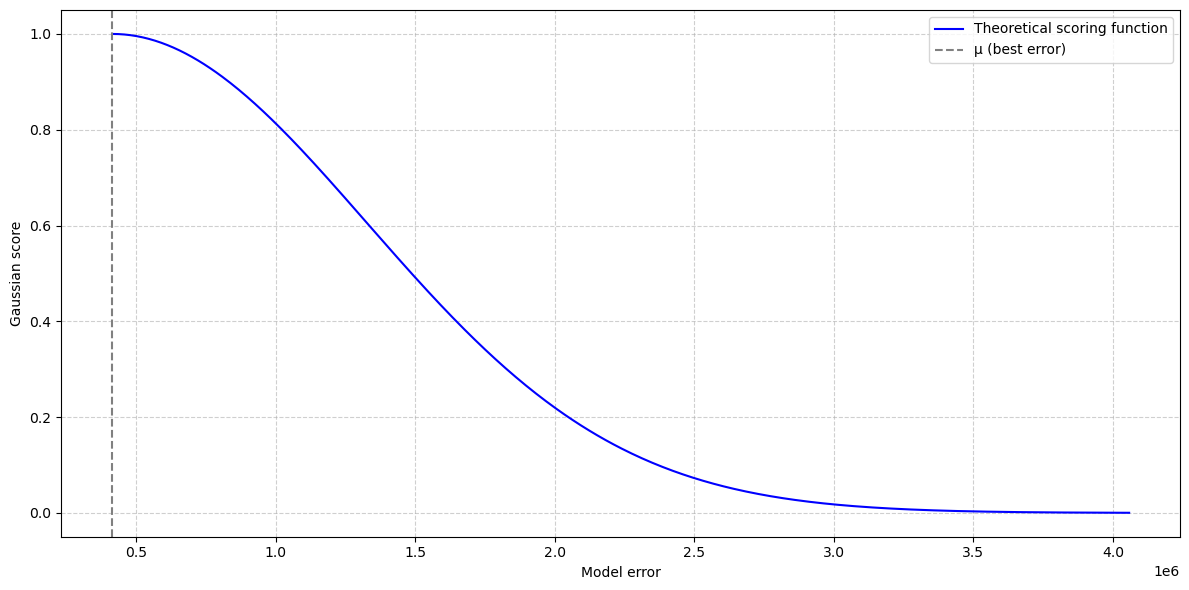

In [28]:
# Generate the theoretical curve
x = np.linspace(classement_modeles.min(), classement_modeles.max(), 500)
gauss_curve = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, gauss_curve, label='Theoretical scoring function', color='blue')
plt.axvline(mu, color='gray', linestyle='--', label='μ (best error)')
plt.xlabel("Model error")
plt.ylabel("Gaussian score")
#plt.title("Gaussian Transformation of Model Errors")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.savefig("courbe_gaussienne.png")
plt.show()

### Create a DataFrame

In [29]:
# Create a DataFrame with error and scores
scores_modeles_seaice = pd.DataFrame({
    'Erreur_moyenne' : classement_modeles,
    'Scores_exp' : scores_exp,
    'Scores_gauss' : scores_gauss,
})

In [31]:
# Display the DataFrame
scores_modeles_seaice.head()

,Erreur_moyenne,Scores_exp,Scores_gauss
modèle_x,,,
INM-CM4-8,4.076449e+05,1.000000,1.000000
INM-CM5-0,7.946032e+05,0.902089,0.918566
CNRM-CM6-1-HR,1.018964e+06,0.849772,0.808968
NESM3,1.401856e+06,0.767401,0.570796
MPI-ESM1-2-HR,1.431614e+06,0.761344,0.551677


In [32]:
# Save the DataFrame in a csv format
scores_modeles_seaice.to_csv("/home/jovyan/private-storage/output_data/scores_modeles_seaice.csv")

## Conclusion

This notebook has provided a comprehensive analysis of sea ice cover simulations by various models. It included data visualizations to compare simulated and observed sea ice extent, identification of outliers to highlight anomalous model behavior, and calculation of absolute and relative errors to quantify model performance. Additionally, models were ranked based on their error metrics, and scoring functions were applied to better distinguish the best and worst performers. Overall, this approach allows for a more informed evaluation and selection of models for future analysis, improving the reliability of sea ice cover simulations.